In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image
import random
import shutil

In [65]:
batch_size = 32
img_height = 300
img_width = 300
path = '/home/steve/Vorlesungen/Artificial_Intelligence_Burghart/KI-Projekt-RKIM22-23/data'

train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1393 files belonging to 4 classes.
Using 1115 files for training.


In [66]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1393 files belonging to 4 classes.
Using 278 files for validation.


In [67]:
class_names = train_ds.class_names
print(class_names)

['broken', 'closed_seal_broken', 'closed_sealed', 'open_broken']


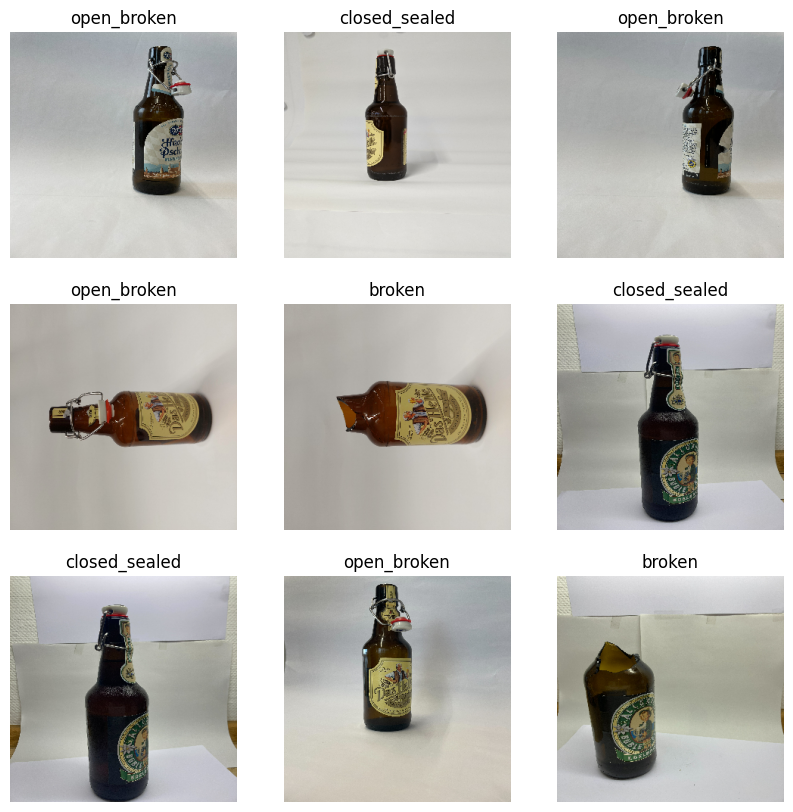

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [69]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [70]:
from tensorflow import keras
from keras import layers
num_classes = len(class_names)

model = keras.models.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 75, 75, 64)       

In [71]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early_stopping = EarlyStopping(
    patience=4
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)

callbacks = [early_stopping,reduce_lr]






In [72]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [73]:
epochs=35
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callbacks]
)

Epoch 1/35


/home/steve/.local/lib/python3.8/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


35/35 [==============================] - 21s 329ms/step - loss: 1.6172 - accuracy: 0.3641 - val_loss: 1.1316 - val_accuracy: 0.4281 - lr: 0.0010
Epoch 2/35
35/35 [==============================] - 9s 259ms/step - loss: 0.8420 - accuracy: 0.6341 - val_loss: 0.7789 - val_accuracy: 0.6619 - lr: 0.0010
Epoch 3/35
35/35 [==============================] - 9s 261ms/step - loss: 0.4809 - accuracy: 0.8009 - val_loss: 0.6528 - val_accuracy: 0.7302 - lr: 0.0010
Epoch 4/35
35/35 [==============================] - 9s 259ms/step - loss: 0.2938 - accuracy: 0.8870 - val_loss: 0.5260 - val_accuracy: 0.7950 - lr: 0.0010
Epoch 5/35
35/35 [==============================] - 9s 258ms/step - loss: 0.1866 - accuracy: 0.9390 - val_loss: 0.5303 - val_accuracy: 0.8237 - lr: 0.0010
Epoch 6/35
35/35 [==============================] - 9s 263ms/step - loss: 0.0705 - accuracy: 0.9776 - val_loss: 0.3917 - val_accuracy: 0.8993 - lr: 0.0010
Epoch 7/35
35/35 [==============================] - 9s 261ms/step - loss: 0.0411

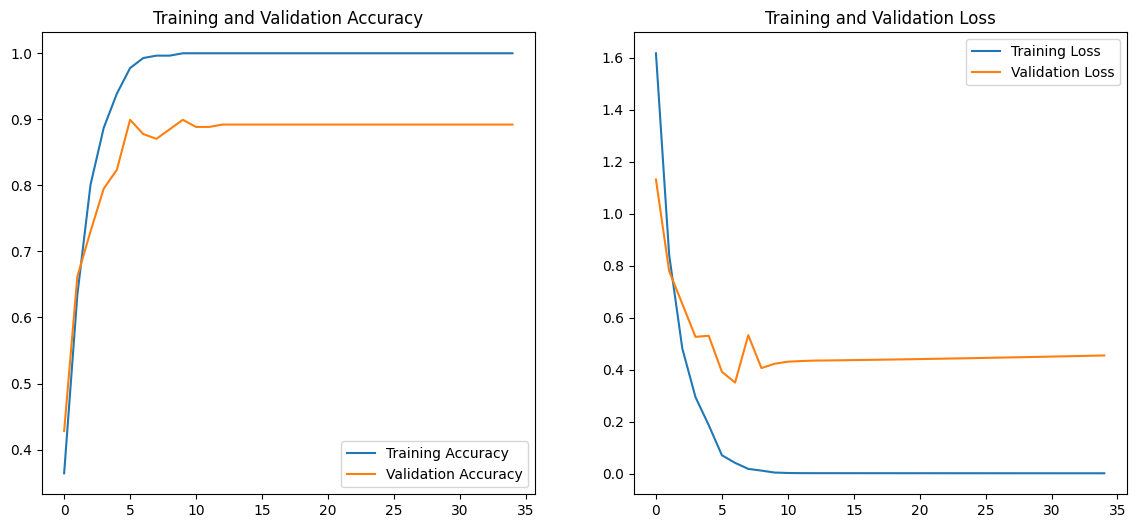

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [81]:
path_test = "/home/steve/Vorlesungen/Artificial_Intelligence_Burghart/KI-Projekt-RKIM22-23/open.jpg"
sunflower_path = tf.keras.utils.get_file('open', 'file://'+path_test)

/home/steve/.keras/datasets/open


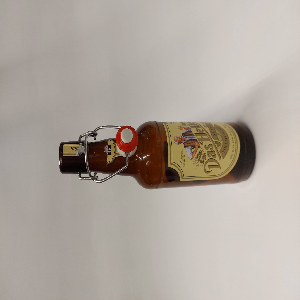

In [82]:

print(sunflower_path)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img


In [83]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 23ms/step
This image most likely belongs to open_broken with a 47.54 percent confidence.
